In [1]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

In [2]:
def print_messages(result, last_n=None):
    """
    Fungsi untuk menampilkan pesan.
    Jika last_n diisi (misal: 2), hanya menampilkan n pesan terakhir.
    """
    messages = result.get("messages", [])
    
    # Jika last_n diberikan, kita slice list-nya (misal: messages[-2:])
    if last_n is not None:
        messages = messages[-last_n:]
    
    for msg in messages:
        role = "😎 USER" if msg.type == "human" else "🤖 BOT"
        print(f"{role}: {msg.content}")

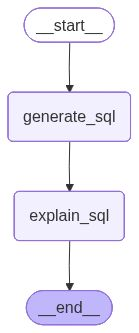

In [15]:
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

# berguna untuk menghasilkan kueri SQL
model_low_temp = ChatOpenAI(model=default_model_name,temperature=0.1)
# berguna untuk menghasilkan keluaran bahasa alami
model_high_temp = ChatOpenAI(model=default_model_name,temperature=0.7)

class State(TypedDict):
    # untuk melacak riwayat percakapan
    messages: Annotated[list, add_messages]
    # masukan
    user_query: str
    # keluaran
    sql_query: str
    sql_explanation: str

class Input(TypedDict):
    user_query: str

class Output(TypedDict):
    sql_query: str
    sql_explanation: str

generate_prompt = SystemMessage(
    """Anda adalah analis data yang membantu yang menghasilkan kueri SQL untuk pengguna berdasarkan
    pertanyaan mereka. Hanya hasilkan sql tanpa format markdown"""
)

def generate_sql(state: State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [generate_prompt, *state["messages"], user_message]
    res = model_low_temp.invoke(messages)
    return {
        "sql_query": res.content,
        # perbarui riwayat percakapan
        "messages": [user_message, res],
    }

explain_prompt = SystemMessage(
    "Anda adalah analis data yang membantu yang menjelaskan kueri SQL kepada pengguna.Hanya hasilkan output saja"
)

def explain_sql(state: State) -> State:
    messages = [
        explain_prompt,
        # berisi kueri pengguna dan kueri SQL dari langkah sebelumnya
        *state["messages"],
    ]
    res = model_high_temp.invoke(messages)
    return {
        "sql_explanation": res.content,
        # perbarui riwayat percakapan
        "messages": res,
    }

builder = StateGraph(State, input=Input, output=Output)
builder.add_node("generate_sql", generate_sql)
builder.add_node("explain_sql", explain_sql)
builder.add_edge(START, "generate_sql")
builder.add_edge("generate_sql", "explain_sql")
builder.add_edge("explain_sql", END)

graph = builder.compile()
png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [17]:
graph.invoke({
  "user_query": "Berapa total penjualan untuk setiap produk?"
})

{'sql_query': 'SELECT product_id, SUM(sales_amount) AS total_sales\nFROM sales\nGROUP BY product_id;',
 'sql_explanation': 'Kueri ini menghitung total penjualan (`SUM(sales_amount)`) untuk setiap produk (`product_id`) dari tabel `sales`. Hasilnya akan menampilkan dua kolom:  \n- `product_id`: ID unik untuk setiap produk.  \n- `total_sales`: Jumlah total penjualan untuk masing-masing produk.  \n\nDengan kata lain, kueri ini memberikan ringkasan total pendapatan yang dihasilkan oleh setiap produk berdasarkan data penjualan.'}